In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# 1.Thu thập dữ liệu

## Dữ liệu sử dụng
Thống kê dữ liệu theo từng ngày các trường hợp mắc bệnh, tử vong, hồi phục từ 22/1/2020 - 20/6/2021
<br>
Các dữ liệu đều được lấy từ kho dữ liệu COVID-19 của Trung tâm Khoa học và Kỹ thuật Hệ thống (CSSE) thuộc Đại học Johns Hopkins (USA)
<br>
Đường link lấy dữ liệu: https://github.com/CSSEGISandData/COVID-19
<br>
Điều kiện để được sử dụng dữ liệu: Trích dẫn 1 đoạn mà người public dữ liệu yêu cầu (Đã trích dẫn ở cuối bài làm)
<br>
Người ta thu thập dữ liệu bằng cách lấy thông tin từ 1 số lượng lớn các trang web. Đa số thì sẽ lấy thông tin từ từng Quốc Gia

In [2]:
confirm_df = pd.read_csv('time_series_covid19_confirmed_global.csv')
death_df = pd.read_csv('time_series_covid19_deaths_global.csv')
recover_df = pd.read_csv('time_series_covid19_recovered_global.csv')
confirm_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,6/11/21,6/12/21,6/13/21,6/14/21,6/15/21,6/16/21,6/17/21,6/18/21,6/19/21,6/20/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,87716,88740,89861,91458,93272,93288,96531,98734,98734,98734
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,132437,132449,132459,132461,132469,132476,132481,132484,132488,132490
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,132727,133070,133388,133742,134115,134458,134840,135219,135586,135821
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,13813,13813,13813,13826,13828,13836,13839,13842,13842,13842
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,36455,36600,36705,36790,36921,37094,37289,37467,37604,37678


## Tiền xử lý
Gom các cột ngày tháng vào 1 cột có tên là Date, tạo ra 1 bảng duy nhất thể hiện tổng số ca mắc, hồi phục và tử vong của các nước theo ngày

In [3]:
dates = confirm_df.iloc[:,4:]
#Không lấy các cột lat và long vì chúng ta không có dự định biểu thị vị trí trên bản đồ thế giới
confirm_df_melt = confirm_df.melt(id_vars=['Province/State', 'Country/Region'], value_vars=dates, var_name='Date', value_name='Confirmed')
death_df_melt = death_df.melt(id_vars=['Province/State', 'Country/Region'], value_vars=dates, var_name='Date', value_name='Deaths')
recover_df_melt = recover_df.melt(id_vars=['Province/State', 'Country/Region'], value_vars=dates, var_name='Date', value_name='Recovered')

In [4]:
#Ghép các giá trị số ca đã xác nhận, số ca tử vong và số ca hồi phục vào dataframe
covid19_df = pd.merge(left=confirm_df_melt, right=death_df_melt, how='left', on=['Province/State', 'Country/Region', 'Date'])
covid19_df = pd.merge(left=covid19_df, right=recover_df_melt, how='left', on=['Province/State', 'Country/Region', 'Date'])
covid19_df.head()

,Province/State,Country/Region,Date,Confirmed,Deaths,Recovered
0,NaN,Afghanistan,1/22/20,0,0,0.0
1,NaN,Albania,1/22/20,0,0,0.0
2,NaN,Algeria,1/22/20,0,0,0.0
3,NaN,Andorra,1/22/20,0,0,0.0
4,NaN,Angola,1/22/20,0,0,0.0


# 2.Khám phá dữ liệu

In [5]:
covid19_df.shape

(143448, 6)

In [6]:
have_duplicated_rows = covid19_df.duplicated().any()
have_duplicated_rows

False

## Số dòng, cột, ý nghĩa của từng dòng và kiểm tra việc lặp
<br>
Dữ liêu có 142336 dòng và 6 cột. Mỗi dòng biểu thị số ca mắc, số ca tử vong và số ca hồi phục tổng đã được xác nhận tại thời điểm thu thập dữ liệu tại Quốc gia (+ Địa điểm) đó
<br>
Dữ liệu mỗi dòng đều có ý nghĩa giống nhau và không dòng nào bị lặp

## Chú thích dữ liệu (Ý nghĩa của từng cột)
__Province_State__: Tên tiểu bang, địa danh,...
<br>
__Country_Region__: Tên quốc gia
<br>
__Date__: Thời gian thu thập dữ liệu
<br>
__Confirmed__: Số ca mắc bệnh đã xác nhận
<br>
__Deaths__: Số ca tử vong đã được xác nhận
<br>
__Recovered__: Số ca hồi phục đã được xác nhận

In [7]:
covid19_df.dtypes

Province/State     object
Country/Region     object
Date               object
Confirmed           int64
Deaths              int64
Recovered         float64
dtype: object

## Kiểu dữ liệu
Cột __Province_State__, __Country_Region__, __Date__ có kiểu dữ liệu object cần xử lý tiếp tục
<br>
Cột __Confirmed__, __Deaths__, __Recovered__ có kiểu dữ liệu numeric. Để đồng hộ hoá thì chúng ta sẽ chuyển kiểu dữ liệu của __Recovered__ từ float64 về int64 như 2 cái trước.

In [8]:
def open_object_dtype(s):
    dtypes = set(s.apply(lambda x: type(x)).unique())
    return dtypes
print(open_object_dtype(covid19_df['Province/State']))
print(open_object_dtype(covid19_df['Country/Region']))
print(open_object_dtype(covid19_df['Date']))

{<class 'str'>, <class 'float'>}
{<class 'str'>}
{<class 'str'>}


In [9]:
covid19_df['Province/State'].unique()

array([nan, 'Australian Capital Territory', 'New South Wales',
       'Northern Territory', 'Queensland', 'South Australia', 'Tasmania',
       'Victoria', 'Western Australia', 'Alberta', 'British Columbia',
       'Diamond Princess', 'Grand Princess', 'Manitoba', 'New Brunswick',
       'Newfoundland and Labrador', 'Northwest Territories',
       'Nova Scotia', 'Nunavut', 'Ontario', 'Prince Edward Island',
       'Quebec', 'Repatriated Travellers', 'Saskatchewan', 'Yukon',
       'Anhui', 'Beijing', 'Chongqing', 'Fujian', 'Gansu', 'Guangdong',
       'Guangxi', 'Guizhou', 'Hainan', 'Hebei', 'Heilongjiang', 'Henan',
       'Hong Kong', 'Hubei', 'Hunan', 'Inner Mongolia', 'Jiangsu',
       'Jiangxi', 'Jilin', 'Liaoning', 'Macau', 'Ningxia', 'Qinghai',
       'Shaanxi', 'Shandong', 'Shanghai', 'Shanxi', 'Sichuan', 'Tianjin',
       'Tibet', 'Unknown', 'Xinjiang', 'Yunnan', 'Zhejiang',
       'Faroe Islands', 'Greenland', 'French Guiana', 'French Polynesia',
       'Guadeloupe', 'Martiniq

In [10]:
covid19_df['Date'] = pd.to_datetime(covid19_df['Date'], format = '%m/%d/%y')
covid19_df['Recovered'] = covid19_df['Recovered'].fillna(0)
covid19_df['Recovered'] = covid19_df['Recovered'].astype('int64')
covid19_df['Province/State'] = covid19_df[['Province/State','Country/Region']].replace(np.nan,'')

In [11]:
num_cols = ['Date','Confirmed','Deaths','Recovered']
def missing_ratio(df):
    return df.isna().mean() * 100
nume_col_profiles_df = covid19_df[num_cols].agg([missing_ratio, 'min', 'max'])
nume_col_profiles_df

,Date,Confirmed,Deaths,Recovered
missing_ratio,0.0,0.0,0.0,0.0
min,2020-01-22 00:00:00,0.0,0.0,0.0
max,2021-06-20 00:00:00,33541887.0,601824.0,28844199.0


## Dữ liệu numeric
<br>
Dữ liệu không có giá trị thiếu
<br>
Dữ liệu không có giá trị bất thường về ngày đầu tiên và ngày cuối cùng thu thập dữ liệu, số ca mắc, tử vong, hồi phục cao nhất tính tới ngày 20/6/2021

In [12]:
cat_cols = list(set(covid19_df.columns) - set(num_cols))
def missing_ratio(df):
    return df.isna().mean() * 100
def num_diff_vals(df):
    return df.nunique()
def diff_vals(df):
    return df.unique()
cate_col_profiles_df = covid19_df[cat_cols].agg([missing_ratio, num_diff_vals, diff_vals])
cate_col_profiles_df

,Country/Region,Province/State
missing_ratio,0.0,0.0
num_diff_vals,194,88
diff_vals,"[Afghanistan, Albania, Algeria, Andorra, Angol...","[, Australian Capital Territory, New South Wal..."


## Dữ liệu categorical
Dữ liệu không có giá trị thiếu
<br>
Dữ liệu có ít quốc gia trên thế giới hơn so với thực tế (194 quốc gia so với 204 quốc gia đã được xác nhận) ngoài ra không còn gì bất thường

# 3. Trả lời câu hỏi

## Câu hỏi
1. Những nước nào có tỉ lệ số người tử vong trên số người hồi phục thấp để chúng ta có thể học tập các biện pháp y tế của họ đồng thời những nước nào có tỉ lệ cao để chúng ta có thể rút kinh nghiệm từ những khó khăn của họ.
<br><br>
2. Trong vòng 1 tuần, 1 tháng qua, nước nào có số người nhiễm mới thấp so với thế giới. Từ đó chúng ta có thể học hỏi về cách phòng bệnh và mở cửa giao thương. Đồng thời chúng ta sẽ tìm những nước có người nhiễm cao để rút kinh nghiệm từ những khó khăn của họ và cảnh báo cho người dân không chủ quan.
<br><br>
3. Kiểm tra và thống kê dữ liệu của Việt Nam để chúng ta hiểu rõ hơn tình hình của chúng ta hiện tại để biết khả năng phòng chống và sự phức tạp của dịch bệnh này ở nước ta như thế nào. (Các tỉ lệ so với thế giới, so với trước đó, tốc độ gia tăng,...)

## Tiền xử lý
Để tính số người tử vong trên số người hồi phục, chúng ta phải lấy số ca nhiễm, số ca tử vong và số ca hồi phục mới nhất để tính. Vì vậy chúng ta sẽ tạo 1 dataframe ứng với mỗi quốc gia sẽ là số ca nhiễm, ca hồi phục và ca tử vong mới nhất

In [13]:
country_df = covid19_df[covid19_df['Date']==max(covid19_df['Date'])].reset_index(drop=True).drop('Date', axis=1)
country_df

,Province/State,Country/Region,Confirmed,Deaths,Recovered
0,,Afghanistan,98734,3934,64401
1,,Albania,132490,2454,129918
2,,Algeria,135821,3631,94571
3,,Andorra,13842,127,13650
4,,Angola,37678,859,31676
...,...,...,...,...,...
273,,Vietnam,13258,66,5229
274,,West Bank and Gaza,312673,3551,306240
275,,Yemen,6885,1355,3953
276,,Zambia,129033,1644,108960


Ta thấy có 278 dòng trong khi chúng ta đã khám phá chỉ có 194 quốc gia được thể hiện nên có thể các quốc gia đã bị trùng lặp do sự phân vùng lãnh thổ "Province/State". Chúng ta cần lấy số liệu của từng quốc gia nên chúng ta sẽ nhóm từng quốc gia lại.

In [14]:
country_df = country_df.groupby('Country/Region')[['Confirmed', 'Deaths','Recovered']].sum().reset_index()
country_df

,Country/Region,Confirmed,Deaths,Recovered
0,Afghanistan,98734,3934,64401
1,Albania,132490,2454,129918
2,Algeria,135821,3631,94571
3,Andorra,13842,127,13650
4,Angola,37678,859,31676
...,...,...,...,...
189,Vietnam,13258,66,5229
190,West Bank and Gaza,312673,3551,306240
191,Yemen,6885,1355,3953
192,Zambia,129033,1644,108960


Dữ liệu đã chuẩn xác bây giờ chúng ta sẽ bắt đầu đến phần trả lời câu hỏi

## Câu 1

## Câu 2

## Câu 3

In [15]:
vietnam_df = country_df[country_df['Country/Region'] == 'Vietnam'].drop('Country/Region', axis = 1)
vietnam_df_date = covid19_df[covid19_df['Country/Region'] == 'Vietnam']\
                    .drop(['Country/Region','Province/State'], axis = 1).reset_index(drop=True)

In [16]:
#31 ngày gần đây
tt_days = vietnam_df_date[-31:]
tt_days.set_index('Date', inplace = True)
#Toàn bộ lịch sử
full_days = vietnam_df_date
full_days.set_index('Date',inplace = True)

Text(0.5, 1.0, 'Full days Confirmed')

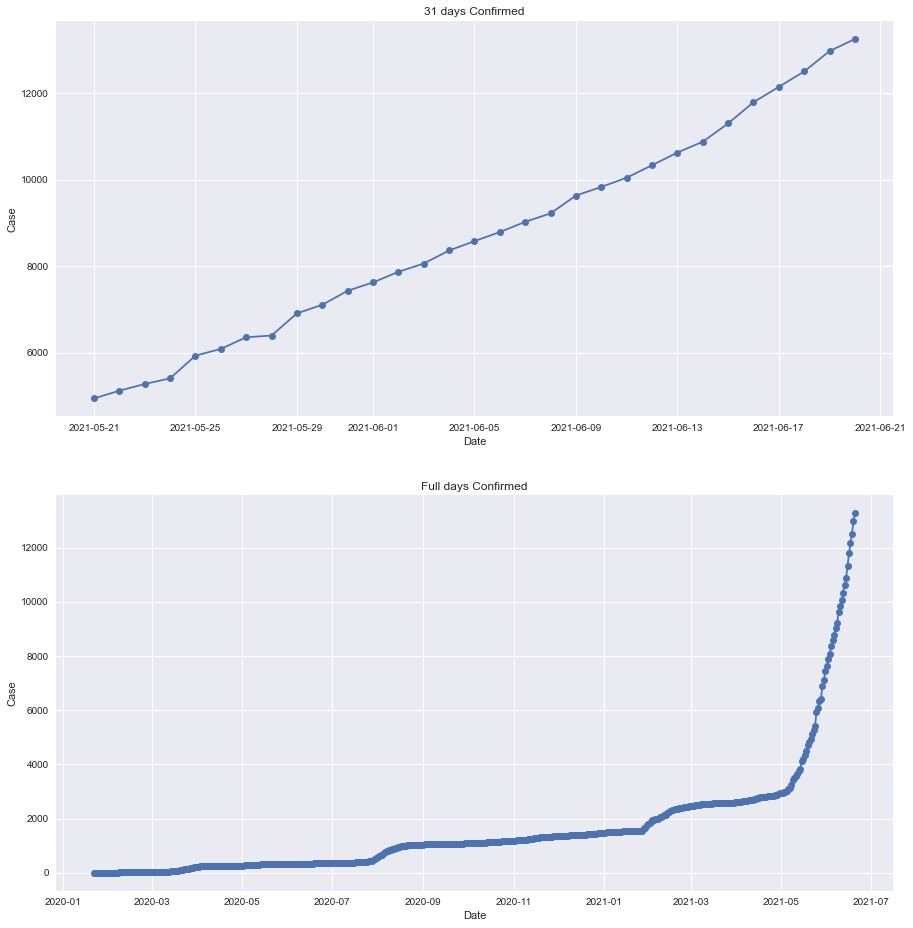

In [17]:
#Sự gia tăng ca nhiễm gần đây
s = tt_days['Confirmed']
s1 = full_days['Confirmed']

plt.style.use('seaborn')
fig, axes = plt.subplots(2, 1,figsize=(15,16))
axes[0].plot(s, marker = "o")
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Case')
axes[0].set_title('31 days Confirmed')
axes[1].plot(s1, marker = "o")
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Case')
axes[1].set_title('Full days Confirmed')

Theo chúng ta đã thấy, 1 tháng qua số ca nhiễm tăng thêm liên tục 1 số lượng lớn và từ đầu tháng 5 dịch bùng phát dữ dội với số ca lây nhiễm gấp 3 lần so với trước đó. Đây là minh chứng cho sự chủ quan và khinh thường dịch bệnh của chúng ta.

Text(0.5, 1.0, 'Full days Deaths')

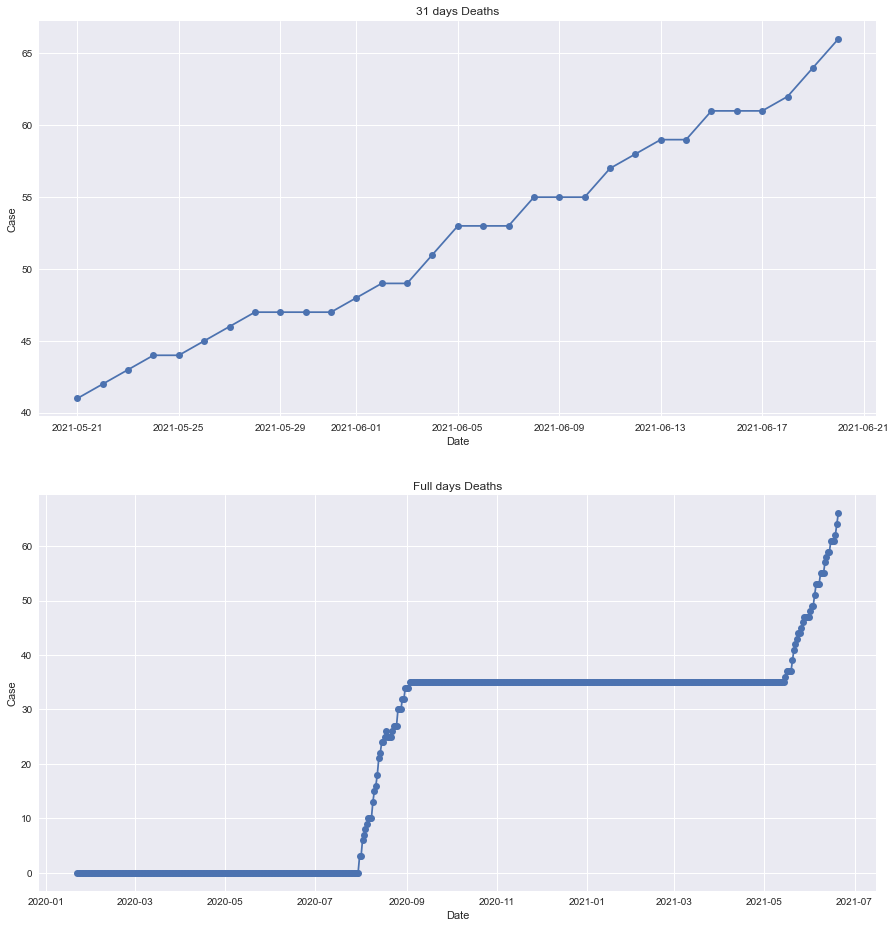

In [18]:
#Sự gia tăng ca tử vong
s = tt_days['Deaths']
s1 = full_days['Deaths']

plt.style.use('seaborn')
fig, axes = plt.subplots(2, 1,figsize=(15,16))
axes[0].plot(s, marker = "o")
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Case')
axes[0].set_title('31 days Deaths')
axes[1].plot(s1, marker = "o")
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Case')
axes[1].set_title('Full days Deaths')

Kéo theo việc gia tăng số ca mắc thì số ca tử vong cũng đã tăng theo. Chúng ta khá may mắn khi đã giứ tỉ lệ tử vong khá thấp khi so sánh với những gì thấy được ở nước ngoài trên mạng. Còn để kiểm tra thật sự chúng cao hay thấp so với thế giới 1 cách chuẩn xác thì chúng ta sẽ tiếp tục tìm hiểu sau

Text(0.5, 1.0, 'Full days Recovered')

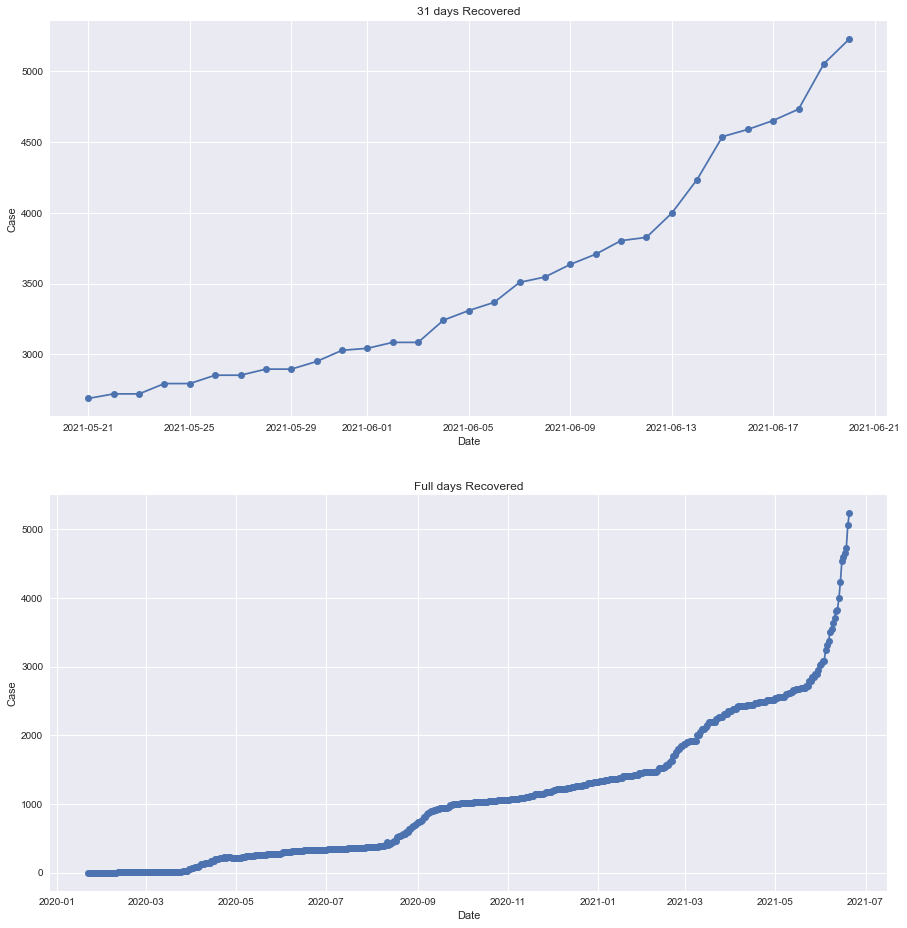

In [19]:
#Sự gia tăng ca hồi phục
s = tt_days['Recovered']
s1 = full_days['Recovered']

plt.style.use('seaborn')
fig, axes = plt.subplots(2, 1,figsize=(15,16))
axes[0].plot(s, marker = "o")
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Case')
axes[0].set_title('31 days Recovered')
axes[1].plot(s1, marker = "o")
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Case')
axes[1].set_title('Full days Recovered')

Đương nhiên với tỉ lệ tử vong thấp thì tỉ lệ hồi phục lại khá cao. Chúng ta cũng sẽ tìm hiểu tỉ lệ của chúng so với thế giới sau

In [20]:
#Số lượng ca nhiễm mới mỗi ngày trong 31 ngày qua
tt_day_before =  vietnam_df_date[-32:-1]
change_each_day = tt_days['Confirmed'].reset_index(drop = True) - tt_day_before['Confirmed'].reset_index(drop = True)
num_change_each_day = pd.DataFrame({'Changed each day':change_each_day})
num_change_each_day.set_index(tt_days.index, inplace = True)

Text(0.5, 1.0, '31 days Changed')

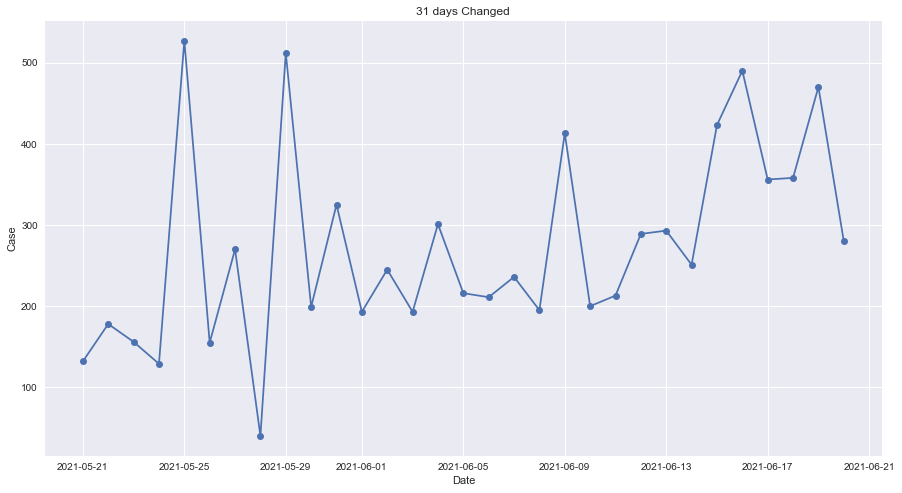

In [21]:
plt.style.use('seaborn')
fig, axes = plt.subplots(1, 1,figsize=(15,8))
axes.plot(num_change_each_day, marker = "o")
axes.set_xlabel('Date')
axes.set_ylabel('Case')
axes.set_title('31 days Changed')

Số lượng ca nhiễm mỗi ngày đang ở mức khá cao với số lượng trung bình khoảng hơn 200 ca nhiễm 1 ngày

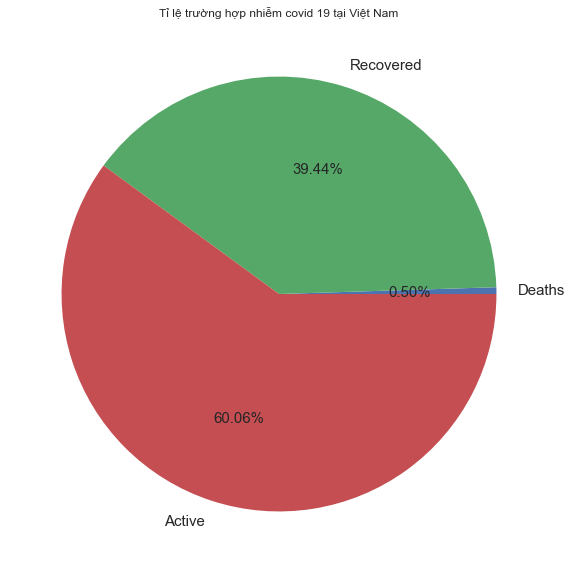

In [22]:
#Tỉ lệ tử vong / hồi phục / còn lại của Việt Nam
percent_chart = vietnam_df.copy()
percent_chart['Active'] = percent_chart['Confirmed'] - percent_chart['Deaths'] - percent_chart['Recovered']
percent_chart.drop('Confirmed', axis = 1, inplace  = True)
labels = percent_chart.columns
rates = (percent_chart.values/percent_chart.values.sum())*100
rates = rates.reshape(-1)

fig, axes = plt.subplots()
plt.title('Tỉ lệ trường hợp nhiễm covid 19 tại Việt Nam')
fig.set_figheight(10)
fig.set_figwidth(10)
axes.pie(rates, labels=labels, autopct='%0.2f%%', textprops={'fontsize': 15})
plt.show()

Theo như biểu đồ này, chúng ta có thể thấy được những ca chưa khỏi bệnh đang chiếm 1 số lượng lớn, gây áp lực cực lớn lên nền y tế nước nhà. Sở dĩ điều này xảy ra vì dịch bùng phát quá nhanh chóng. Nếu cứ gia tăng nhiều như thế này thì tỉ lệ người bệnh sẽ còn lên rất cao. Vì thế chúng ta cần thực hiện nghiêm túc những quy tắc phòng dịch để làm giảm áp lực lên nên y tế nước nhà.

In [23]:
#Xếp hạng ca mắc, tỉ lệ tử vong/hồi phục của VN so với thế giới
compare_table = country_df[['Country/Region','Confirmed','Deaths','Recovered']]
compare_confirmed = compare_table.sort_values('Confirmed', ascending = False)
compare_confirmed.index = np.arange(1, len(compare_confirmed) + 1)
compare_confirmed = compare_confirmed[compare_confirmed['Country/Region'] == 'Vietnam'] \
                        .drop(['Deaths','Recovered'], axis = 1)
compare_confirmed

,Country/Region,Confirmed
144,Vietnam,13258


Số lượng ca mắc của chúng ta chỉ xếp hạng 144/194 quốc gia và vùng lãnh thổ được xét. Chúng có thể coi là khá thấp so với hiện tại nhưng chúng ta cần phải xét đến các yếu tố về kinh tế, khả năng y tế... nên không thể lấy chỉ số này mà chủ quan được.

In [24]:
compare_table['Deaths per Recovered'] = compare_table['Deaths'] / compare_table['Recovered'] * 100
compare_percent_death = compare_table.sort_values('Deaths per Recovered', ascending = False)
compare_percent_death.index = np.arange(1, len(compare_percent_death) + 1)
compare_percent_death = compare_percent_death[compare_percent_death['Country/Region'] == 'Vietnam']\
                                                .drop(['Confirmed','Deaths','Recovered'], axis = 1)
compare_percent_death

,Country/Region,Deaths per Recovered
140,Vietnam,1.262192


Một điểm sáng trong tình hình dịch bệnh diễn biến khá phức tạp hiện nay là tình hình chữa bệnh của chúng ta khá tốt. Tỉ lệ người tử vong/ số người hồi phục chỉ đứng ở hạng 140/194 quốc gia và vùng lãnh thổ được xét. Vì vây khi biết mình bị nhiễm covid-19 tốt nhất không nên hoảng loạn, thành khẩn khai báo và tuân thủ các biện pháp cách ly, chữa bệnh.

In [25]:
#Tỉ lệ số ca mắc mới trong 1 tuần (1 tháng)/ số ca nhiễm của VN so với thế giới
last_week = covid19_df[covid19_df['Date']==max(covid19_df['Date'])-timedelta(days=7)] \
                .groupby('Country/Region')[['Confirmed', 'Deaths','Recovered']].sum().reset_index()
last_month = covid19_df[covid19_df['Date']==max(covid19_df['Date'])-timedelta(days=31)] \
                .groupby('Country/Region')[['Confirmed', 'Deaths','Recovered']].sum().reset_index()
last_month_1000 = last_month[last_month['Confirmed'] > 1000].reset_index(drop = True)
country_df_1000 = country_df[country_df['Country/Region'].isin(last_month_1000['Country/Region'])].reset_index(drop = True)
last_week_1000 = last_week[last_week['Country/Region'].isin(last_month_1000['Country/Region'])].reset_index(drop = True)

In [26]:
week_change_percent = (country_df_1000['Confirmed'] - last_week_1000['Confirmed']) / last_week_1000['Confirmed'] * 100
percent_last_week = pd.DataFrame({'Country/Region':country_df_1000['Country/Region'], '1 week percent change':week_change_percent})
percent_last_week = percent_last_week.sort_values('1 week percent change', ascending = False)
percent_last_week.index = np.arange(1, len(percent_last_week) + 1)
percent_last_week = percent_last_week[percent_last_week['Country/Region'] == 'Vietnam']
percent_last_week

,Country/Region,1 week percent change
1,Vietnam,24.722484


Trong vòng 1 tuần từ 13/6/2021 - 20/6/2021, nước ta đã tăng số ca nhiễm hơn 24% so với trước đó và đang đứng cao nhất thế giới về tỉ lệ gia tăng covid-19 so với trước đó (Chỉ xét các quốc gia và vùng lãnh thổ có hơn 1000 ca mắc từ tháng trước). Điều này thể hiện việc diễn biến dịch bệnh ở nước ta đang cực kỳ căng thẳng và mọi người phải đồng lòng để đẩy lùi dịch bệnh

In [27]:
month_change_percent = (country_df_1000['Confirmed'] - last_month_1000['Confirmed']) / last_month_1000['Confirmed'] * 100
percent_last_month = pd.DataFrame({'Country/Region':country_df_1000['Country/Region'], '1 month percent change':month_change_percent})
percent_last_month = percent_last_month.sort_values('1 month percent change', ascending = False)
percent_last_month.index = np.arange(1, len(percent_last_month) + 1)
percent_last_month = percent_last_month[percent_last_month['Country/Region'] == 'Vietnam']
percent_last_month

,Country/Region,1 month percent change
2,Vietnam,175.691412


Và với việc trong 1 tháng từ 20/5/2021 đến 20/6/2021, nước ta đã gia tăng 175% số ca nhiễm so với trước đó và đứng thứ 2 thế giới (Chỉ xét các quốc gia và vùng lãnh thổ có hơn 1000 ca mắc từ tháng trước). Một tốc độ lây lan nhanh khủng khiếp chỉ đứng sau Đài Loan. Sau khi thấy 2 tỉ lệ này chúng ta đã hiểu vì sao nhà nước đang triển khai gắt gao việc tiêm vaccine và xét nghiệm diện rộng.
<br>
Chúng ta cần phải thực hiện đúng quy tắc 5K và tuân theo mọi chỉ thị của nhà nước để cùng nhau đẩy lùi dịch bệnh này.

In [28]:
#Tỉ lệ lây lan của Việt Nam so với thế giới
percent_change_world_week = (country_df['Confirmed'] - last_week['Confirmed']) / (country_df['Confirmed'] - last_week['Confirmed']).sum()
percent_world_week = pd.DataFrame({'Country/Region':country_df['Country/Region'], '1 week percent change':percent_change_world_week})
percent_world_week = percent_world_week.sort_values('1 week percent change', ascending = False)
percent_world_week.index = np.arange(1, len(percent_world_week) + 1)
percent_world_week = percent_world_week[percent_world_week['Country/Region'] == 'Vietnam']
percent_world_week

,Country/Region,1 week percent change
67,Vietnam,0.001041


In [29]:
percent_change_world_month = (country_df['Confirmed'] - last_month['Confirmed']) / (country_df['Confirmed'] - last_month['Confirmed']).sum()
percent_world_month = pd.DataFrame({'Country/Region':country_df['Country/Region'], '1 month percent change':percent_change_world_month})
percent_world_month = percent_world_month.sort_values('1 month percent change', ascending = False)
percent_world_month.index = np.arange(1, len(percent_world_month) + 1)
percent_world_month = percent_world_month[percent_world_month['Country/Region'] == 'Vietnam']
percent_world_month

,Country/Region,1 month percent change
81,Vietnam,0.000635


Dù tỉ lệ lây lan trong nước so với trước đó rất nhanh nhưng mọi người cần chú ý nhưng không nên hoảng loạn vì tỉ lệ số người mắc mới ở VN vẫn còn rất thấp so với thế giới (Hạng 67 trong 1 tuần và Hạng 81 trong 1 tháng). 
<br>
Sự khác biệt ở việc nước ta trước đó đã phòng chống dịch bệnh khá tốt nên khi mỗi ngày có hàng trăm ca bệnh như thế này chúng ta sẽ cảm tưởng nó rất nhiều.
<br>
Sở dĩ tôi nêu lên việc tỉ lệ gia tăng rất nhanh để chúng ta bớt chủ quan với dịch bệnh và đồng lòng đẩy lùi dịch bệnh chứ không muốn chúng ta có 1 sự hoang mang, sợ hãi gây rối loạn trong việc phòng chống dịch bệnh

# 4.Nhìn lại quá trình làm đồ án

Trần Quốc Long:
<br><br>
+Khó khăn:
<br><br>
Tìm chủ đề cho dữ liệu, xác minh xem nguồn dữ liệu có đáng tin cậy không, tìm hiểu kĩ về quy tắc và điều kiện để được sử dụng dữ liệu và liệu chủ đề đó có dễ để đặt câu hỏi và có câu trả lời hợp lý không.
<br>
Xử lý nguồn dữ liệu để tạo thành 1 bảng dữ liệu hoàn chỉnh để thuận tiện cho việc khám phá và trả lời câu hỏi.
<br>
Cách để mô hình hoá dữ liệu lên một cách hợp lý và trả lời sau khi khám phá để thể hiện việc khám phá như thế này thì trả lời được câu hỏi gì.
<br>
Chưa tiếp xúc với Github nhiều nên khó khăn trong việc sử dụng công cụ này.
<br><br>
+Kĩ năng học được:
<br><br>
Cách sử dụng Github để làm việc nhóm với người khác, sử dụng trello để lập thời gian biểu.
<br>
Kĩ năng phân chia công việc và phối hợp làm việc hợp lý với partner
<br>
Một số cách mô hình hoá bằng matplotlib, một số cách xử lý mới chưa sử dụng bao giờ như pandas melt.

Trần Đức Anh:
<br><br>
+Khó khăn:
<br><br>
Suy nghĩ câu hỏi hợp lý để có 1 câu trả lời có ý nghĩa dựa trên dữ liệu đã được thu thập
<br>
Cách sử dụng Github để làm việc nhóm vì chưa sử dụng nhiều
<br>
Cách sử dụng headline để trình bày bài báo cáo
<br><br>
+Kĩ năng học được
<br><br>
Cách làm việc nhóm, sử dụng Github và trello để làm việc nhóm
<br>
Kĩ năng phân chia công việc và phối hợp làm việc hợp lý với partner
<br>
Một số công cụ, chức năng để giúp trình bày bài báo cáo

Nhóm:
<br>
Chúng em thấy thời gian hiện tại đã ổn. Nếu có thêm thời gian thì có thể bọn em sẽ xem xét lại các câu hỏi và các câu trả lời cho hợp lý hơn vì nhiều khi ý tưởng bất ngờ nảy ra hay bỗng dưng phát hiện lỗi sai  ;-).

# 5.Tài liệu tham khảo

Tài liệu pandas: https://pandas.pydata.org/docs/reference/index.html
<br>
Tài liệu về covid-19 của trường Đại học John Hopkins: https://github.com/CSSEGISandData/COVID-19
<br>
Tài liệu vẽ matplotlib: https://matplotlib.org/stable/api/index.html
<br>
Nguồn tham khảo 1 số vấn đề gặp phải khi làm đồ án: https://stackoverflow.com/

Dong E, Du H, Gardner L. An interactive web-based dashboard to track COVID-19 in real time. Lancet Inf Dis. 20(5):533-534. doi: 10.1016/S1473-3099(20)30120-1